In [103]:
import numpy as np # 행렬연산
import matplotlib.pyplot as plt # 시각화

import torch # 파이토치
import torch.nn as nn # 파이토치 모듈
import torch.nn.init as init # 초기화 관련 모듈 
import torch.optim as optim #최적화함수
from torch.utils.data import DataLoader # 데이터셋을 학습에 용이하게 바꿈
from torch.utils.data import Dataset
import torch.nn.functional as F # 자주 쓰는 함수를 F로 따로 가져옴
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


batch_size = 32
learning_rate = 0.01
num_epoch = 10

In [104]:
df = pd.read_csv("C:/Users/user/wetie/3.24/log.csv")  # 너의 CSV 파일 경로
X = df.drop("score", axis=1).values
y = df["score"].values

scaler = StandardScaler()
X = scaler.fit_transform(X) ## 정규화 시키는 과정

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1) ## tensor으로의 변환

In [105]:
## Dataset 클래스 만들기
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx] 


## 데이터셋 분리 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
# 전체의 20%만을 테스트셋으로 사용한다. 

train_dataset = DiabetesDataset(X_train, y_train)
test_dataset = DiabetesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

In [106]:
class MLP(nn.Module): # 메타클래스 nn.Module 상속받아 MLP 클래스 생성 (몰라도됨)
	def __init__(self): 
		super(MLP, self).__init__()

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # layer 생성
        self.fc1 = nn.Linear(5, 100) # input 값은 ABCDE  이렇게 5개이다!
        self.fc2 = nn.Linear(100, 200)
        self.fc3 = nn.Linear(200, 150)
        self.fc4 = nn.Linear(150, 30)
        self.fc5 = nn.Linear(30, 1)  #회귀선은 결국 한 개만 필요하니까!!)
        
        self.dropout = nn.Dropout(0.5) # 연산마다 50% 비율로 랜덤하게 노드 삭제... 나중에
        
        self.batch_norm1 = nn.BatchNorm1d(100) # 1dimension이기 때문에 BatchNorm1d를 사용함.
        self.batch_norm2 = nn.BatchNorm1d(200)
        self.batch_norm3 = nn.BatchNorm1d(150)
        self.batch_norm4 = nn.BatchNorm1d(30)

    def forward(self, x): # 모델의 연산 순서를 정의
    # 1st layer
        x = x.view(-1, 5)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x) # activation function
        x = self.dropout(x)
    # 2nd layer
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout(x)
    # 3nd layer
        x = self.fc3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.dropout(x)
    # 4nd layer
        x = self.fc4(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.dropout(x)
    # 5rd layer
        x = self.fc5(x)
        return x

In [107]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

model= MLP()
model.apply(weight_init)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss() ##회귀함수이기 때문에 MSE를 사용함!!!

In [108]:
def train(model, train_loader, optimizer):
    model.train() # 모델 상태를 '학습중'으로 변경
    for batch_idx, (score, predict) in enumerate(train_loader): # X, y로 이루어진 train set
        optimizer.zero_grad() # 최적화 초기화
        output = model(score) #  모델에 input을 넣어서 예측값을 구한다
        loss = loss_fn(output, predict) # 손실함수, error 계산
        loss.backward() # 손실 함수 기준으로 역전파 설정
        optimizer.step() # 역전파 진행 및 가중치 업데이트

In [109]:
def evaluate(model, test_loader):
    model.eval() # 모델 상태를 '평가중' 으로 변경
    test_loss = 0
    y_preds = []
    x_trues = []

    with torch.no_grad(): # 모델의 평가 단계이므로 gradient가 업데이트 되지 않도록 함
        for score, predict in test_loader:
            output = model(score)
            test_loss += loss_fn(output, predict).item() # loss 누적
            y_preds.append(output.numpy())
            x_trues.append(predict.numpy())

    # numpy 배열로 이어붙이기
    y_pred = np.vstack(y_preds)
    y_true = np.vstack(x_trues)
    
    test_loss /= len(test_loader.dataset) # loss 평균값 계산
    r2 = r2_score(y_true, y_pred) #r^2결정계수 구하기
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return test_loss, r2, rmse

In [110]:
# 결과를 저장할 리스트
epoch_list = []
test_loss_list = []
rmse_list = []
r2_list = []

for epoch in range(1, num_epoch + 1):
    train(model, train_loader, optimizer)
    test_loss, r2, rmse = evaluate(model, test_loader)
    
    epoch_list.append(epoch)
    test_loss_list.append(test_loss)
    rmse_list.append(rmse)
    r2_list.append(r2)
    
    print("[EPOCH: {}], \tTest Loss: {:.4f}, \tRMSE: {:.6f}, \tR2: {:.5f}%".format(
        epoch, test_loss , rmse , r2
    ))

[EPOCH: 1], 	Test Loss: 1.1501, 	RMSE: 6.039862, 	R2: -1.02584%
[EPOCH: 2], 	Test Loss: 0.9307, 	RMSE: 5.438706, 	R2: -0.64264%
[EPOCH: 3], 	Test Loss: 0.4815, 	RMSE: 3.912336, 	R2: 0.14999%
[EPOCH: 4], 	Test Loss: 0.5797, 	RMSE: 4.289655, 	R2: -0.02187%
[EPOCH: 5], 	Test Loss: 0.3448, 	RMSE: 3.308636, 	R2: 0.39208%
[EPOCH: 6], 	Test Loss: 0.3398, 	RMSE: 3.284795, 	R2: 0.40081%
[EPOCH: 7], 	Test Loss: 0.3488, 	RMSE: 3.328358, 	R2: 0.38481%
[EPOCH: 8], 	Test Loss: 0.2389, 	RMSE: 2.754257, 	R2: 0.57873%
[EPOCH: 9], 	Test Loss: 0.2846, 	RMSE: 3.005531, 	R2: 0.49836%
[EPOCH: 10], 	Test Loss: 0.1816, 	RMSE: 2.402027, 	R2: 0.67959%


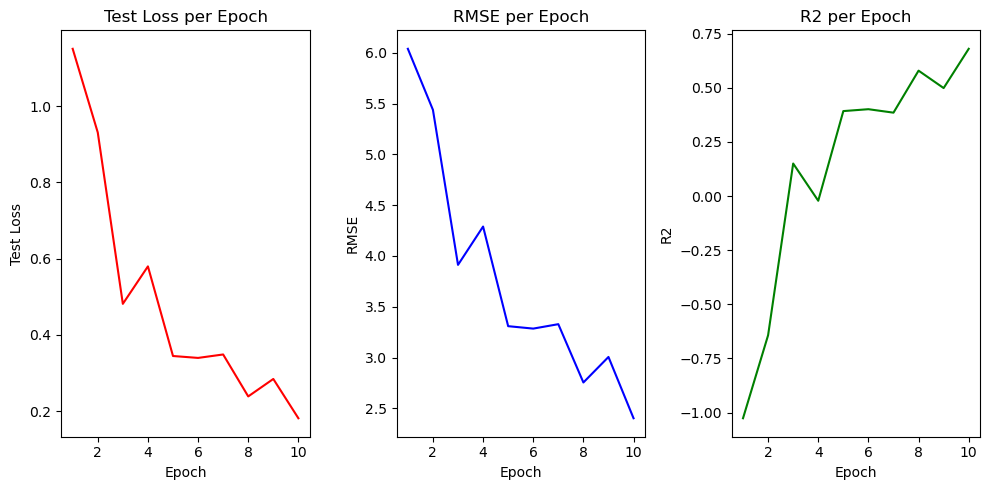

In [111]:
# 시각화
plt.figure(figsize=(10, 5))

# Test Loss
plt.subplot(1, 3, 1)
plt.plot(epoch_list, test_loss_list, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss per Epoch')

# RMSE
plt.subplot(1, 3, 2)
plt.plot(epoch_list, rmse_list, label='RMSE', color='blue')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE per Epoch')

# R2
plt.subplot(1, 3, 3)
plt.plot(epoch_list, r2_list, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.title('R2 per Epoch')

plt.tight_layout()
plt.show()